<!-- ![RWTH Logo](https://www.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaaaaagazb) -->
![iAMB Logo](https://www.iamb.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaaaanwtny)
# Biolog File Data Analysis

* Execute a single cell: <span class="fa-play fa"></span>
* Execute all cells: Menu: Run <span class="fa-chevron-right fa"></span> Run All Cells
* To reboot kernel: <span class="fa-refresh fa"></span>

Find more in the reference (menu: Help <span class="fa-chevron-right fa"></span> Jupyter Reference).

## Introduction

Description Biolog system.


In [1]:
import os
import csv
import string
from datetime import date
from itertools import compress

import matplotlib.pyplot as plt
%matplotlib inline

from iambcodes.biolog import *
from iambcodes.rates import read_ConfFile

In [4]:
# Load existing configuration file, or leave the list empty
ConfFile = None
Workflow = 'BiologData'
# Comment for the config file
ConfComment = '# This file contains the parameters used for analysis of BIOLOG carbon substrate test plates.'
if ConfFile:
    print('Loading analysis config file:')
    Par_Dict = read_ConfFile(ConfFile)
    if Par_Dict['Workflow']==Workflow:
        print('Configuration file fits workflow.')
    else:
        print('ERROR: Configuration file of parameters not suited for the workflow.')
        ConfFile = ''

In [7]:
# Load existing configuration file, or leave the list empty
# For automatic reading of directory, e.g. in cloud use:
# Target_Dir = os.path.join(os.getcwd(), 'MFA')
Target_Dir = os.path.join(os.getcwd(), '..', 'Data', 'BIOLOG_Data') if not ConfFile else Par_Dict['Target_Dir']
BiologFile = 'BIOLOG_StandardFormat.xlsx' if not ConfFile else Par_Dict['BiologFile']
BiologFileAddress = os.path.join(Target_Dir, BiologFile)

# Output Files
# All files are attached with the current date
Today = date.today().strftime('%y%m%d')
# Choose image file type, e.g. svg, png, pdf, eps
ImageType = 'png' if not ConfFile else Par_Dict['ImageType']
print('Workspace initiated.')

Workspace initiated.


### Import data and plot the mean OD

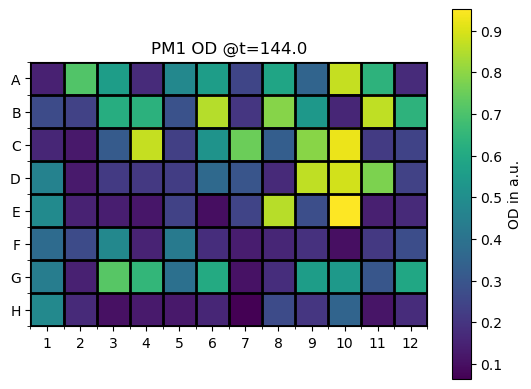

In [8]:
Today = date.today().strftime('%y%m%d')
PM = 'PM1' if not ConfFile else Par_Dict['PM']
# FileName = os.path.join(Target_Directory, '{}_newStandard.xlsx'.format(PM))
PM_mean, PM_stdv = ImportXls(BiologFileAddress)
# extract time vector from the first column
TimeSample = -1
Time = PM_mean.iloc[:,0].values

Plot_Title = '{} OD @t={}'.format(PM, Time[TimeSample])
Colorbar_Name = 'OD in a.u.'
# None if no figure export
FigureFile = None #'{}_OdMean-FinalT.svg'.format(PM) #None
if FigureFile:
    FigureFile = os.path.join(Target_Directory, '{}_{}'.format(Today, FigureFile))

# Processing data
VisualizeWell(PM_mean.iloc[TimeSample,1:].values, plot_title=Plot_Title, plot_z_name=Colorbar_Name, export_file=FigureFile)

### Plot relative standard deviation of OD

In [9]:
Plot_Title = '{} OD @t={}'.format(PM, Time[TimeSample])
Colorbar_Name = 'OD in a.u.'
FigureFile = None #'{}_Well-Stdv.png'.format(PM)
if FigureFile:
    FigureFile = os.path.join(Target_Directory, '{}_{}'.format(Today, FigureFile))

PM_relStdv = PM_stdv.iloc[TimeSample,1:].values / PM_mean.iloc[TimeSample,1:].values
VisualizeWell(PM_relStdv, plot_title=Plot_Title, plot_z_name=Colorbar_Name, export_file=FigureFile)

### Histogramm of ODs

In [10]:
Plot_Title = '{} OD @t={}'.format(PM, Time[TimeSample])
Colorbar_Name = 'in a.u./h'
bins = 20
xlabel = 'OD'
ylabel = 'Frequency'
FigureFile =  '{}_HistFinalT.svg'.format(PM) #'{}_HistFinalT.png'.format(PM) # None if no figure export
if FigureFile:
    FigureFile = os.path.join(Target_Dir, '{}_{}'.format(Today, FigureFile))

# mySlope = SlopeCalc(PM1_mean.values, zero_max=True)
plt.hist(PM_mean.iloc[TimeSample,1:].values, bins=bins)
plt.title(Plot_Title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
if FigureFile:
    plt.savefig(FigureFile)
plt.show()


### Set activity threshold and export substrate activity

In [11]:
# loading PM well substrates and ids
PM_List_Name = os.path.join(Target_Dir, '{}_SubstrateList.csv'.format(PM))
with open(PM_List_Name, newline='') as f:
    reader = csv.reader(f)
    lines = [(line[0].split(';')) for line in reader]
    
PMNames = list(np.array(lines)[:,0])
PMIDs = list(np.array(lines)[:,1])
myWellIDs = WellIDs()

BIOLOG substrate use stored as: /home/ulf/Documents/2111_iambjudas/Content/../Data/BIOLOG_Data/240117_PM1_SubstrateUse.csv


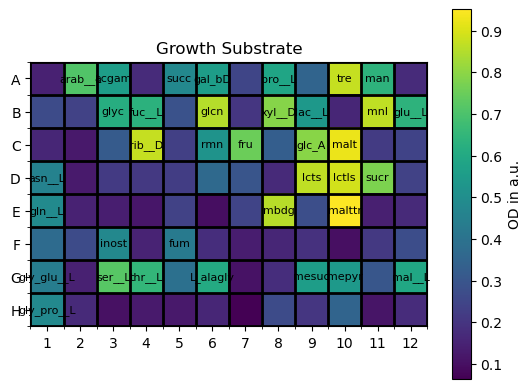

In [12]:
# Define threshold of OD which is defined as active substrate usage for growth
Activity_Thresh = float(input('Activity_Thresh:')) if not ConfFile else float(Par_Dict['Activity_Thresh'])
PMTruth = PM_mean.iloc[TimeSample,1:].values>Activity_Thresh
Active_File = 'SubstrateUse.csv'
File = os.path.join(Target_Dir, '{}_{}_{}'.format(Today, PM, Active_File))

with open(File, 'w') as f:
    for Sub, ID, Well, Act in zip(PMNames, PMIDs, myWellIDs, PMTruth):
        mySubstrate = '{},{},{},{}\n'.format(Well, Sub, ID, Act)
        f.write(mySubstrate)
FigureFile = '{}_OdMean-FinalT+Substrates.png'.format(PM)
if FigureFile:
    FigureFile = os.path.join(Target_Dir, '{}_{}'.format(Today, FigureFile))
    print('BIOLOG substrate use stored as: {}'.format(File))

VisualizeWellSubstrate(PM_mean.iloc[TimeSample,1:].values, PMIDs, PMTruth, plot_title='Growth Substrate', plot_z_name='OD in a.u.', export_file=FigureFile)

### Export parameters to configuration file

In [ ]:
# Storing parameters in dictionary
# https://stackoverflow.com/questions/3972872/python-variables-as-keys-to-dict
loc=locals()
Par_Dict = {i: loc[i] for i in ('Workflow', 'Today', 'Target_Dir', 'BiologFile', 'ImageType', 'PM', 'Activity_Thresh')}

# constructing the config.txt file
ConfName = '{}_JUDAS-BiologData_{}_config.txt'.format(Today, os.path.splitext(BiologFile)[0])
ConfAddress = os.path.join(Target_Dir, ConfName)
with open(ConfAddress, 'w') as f:
    print(ConfComment, file=f)
    for key, value in Par_Dict.items():
        print('{}: {}'.format(key, value), file=f)
